### ZNE Run
- {8, 15, 20, 25, 28}-qubit GHZ echo circuit with 4096 shots x3 (for averaging).
- Batch mode suitable with PUB as [(isa_ghz)] 
- Normal Transpilation (isa_ghz) :- Transpiling for backend with optimization_level = 3

In [1]:
import sys
import os

# Add project root (one level up from 'notebooks')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
# email: uthuppukurian@gmail.com

token = "zh1lkXLoFZSN2PXRYM1VnjYJTW3Q1PCjhEROLC_cmtU4"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    token=token,
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/858d1cfb46bf4703b9189b11b4f9cbfa:3cb3ee53-f86c-4e7b-972a-1ce9eb93bb89::",
    channel="ibm_quantum_platform",
    overwrite=True,
    set_as_default=True,
    name="qamp-2025",
)

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    EstimatorOptions,
    Batch,
)
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as AerEstimator, SamplerV2 as AerSampler
from qiskit.primitives import StatevectorEstimator as SVEstimator
from adaptive_error_mitigation.analytics import (
    extract_basic_features,
    get_qubit_layout_mapping,
    extract_backend_metrics,
    calculate_derived_noise_metrics,
    analyze_qubit_idling,
)
from qiskit.providers.backend import BackendV2 as Backend
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def prepare_echo_ghz_with_xs(n_qubits: int):
    ## Prepares echo circuit with for ghz circuit. Xs at the end to make the expectation value 1.
    # Create GHZ state
    ghz = QuantumCircuit(n_qubits)
    ghz.h(0)
    for i in range(n_qubits - 1):
        ghz.cx(i, i + 1)

    # Loschmidt echo circuit: GHZ → barrier → GHZ† → measurement
    circuit = QuantumCircuit(n_qubits)
    circuit.compose(ghz, inplace=True)
    circuit.barrier()
    circuit.compose(ghz.inverse(), inplace=True)
    circuit.x(range(n_qubits))

    return circuit


def naked_estimator(mode):
    ## Estimator with no error mitigation or supression for any mode (job, batch). ALL OPTIONS ARE DISABLED.
    config_est_options = {
        "dynamical_decoupling": {"enable": False},
        "twirling": {"enable_gates": False, "enable_measure": False},
        "resilience_level": 0,
        "resilience": {
            "zne_mitigation": False,
        },
    }

    estimator_options = EstimatorOptions(**config_est_options)
    estimator = Estimator(mode=mode, options=estimator_options)
    return estimator

def zne_gt_estimator(mode):
## Estimator with no error mitigation or supression for any mode (job, batch). ALL OPTIONS ARE DISABLED.
    config_est_options = {
        "dynamical_decoupling": {"enable": False},
        "twirling": {"enable_gates": True, "enable_measure": False},
        "resilience_level": 0,
        "resilience": {
            "zne_mitigation": True,
            "zne": {
                "amplifier": "gate_folding",
                "noise_factors": (1, 3, 5),
                "extrapolator": "exponential",
            },
        },
    }

    estimator_options = EstimatorOptions(**config_est_options)
    estimator = Estimator(mode=mode, options=estimator_options)
    return estimator


def pm_for_backend(bknd, opt_level=3, seed=42069):
    ## Returns a PassManager from generate_preset_pass_manager for given opt_level and backend(bknd)
    pm = generate_preset_pass_manager(
        optimization_level=opt_level,
        backend=bknd,
        seed_transpiler=seed,
    )
    return pm


def create_isa_observables(isa_circuit_dict, pauli_char="Z"):
    ## Returns a dict of ISA observables with layouts applied, matching the input isa_circuit_dict keys.
    isa_observables = {}

    for key, isa_qc in isa_circuit_dict.items():
        # 1. Parse qubit count from key
        num_qubits = int(key)

        # 2. Create the logical observable (e.g., "ZZZ")
        observable = SparsePauliOp(pauli_char * num_qubits)

        # 3. Apply the layout from the transpiled circuit
        isa_obs = observable.apply_layout(isa_qc.layout)

        isa_observables[key] = isa_obs

    return isa_observables


def transpile_for_dd(circuit, dd_pm):
    isa_dd_circuit = dd_pm.run(circuit)
    return isa_dd_circuit


def get_h_zne(qc, backend):
    # 1. Extract required metrics using your helper functions
    qubits_used = extract_basic_features(qc)["qubits_used"]
    ons = calculate_derived_noise_metrics(qc, backend)["overall_noise_sensitivity"]
    t2_avg = extract_backend_metrics(qc, backend)["avg_t2_time"]

    # 2. Get circuit duration from the backend target
    duration_ns = qc.estimate_duration(backend.target)

    # 3. Calculate H_ZNE (Handling division by zero)
    if t2_avg == 0:
        return 0.0

    h_zne = ons + qubits_used * (duration_ns / t2_avg)
    return h_zne

In [5]:
QUBIT_SET = [8, 15, 20, 25, 28]

In [6]:
## Prepare circuit dict
circuit_dict = {f"{i}": prepare_echo_ghz_with_xs(n_qubits=i) for i in QUBIT_SET}
circuit_dict

{'8': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d540786150>,
 '15': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d540c74450>,
 '20': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d540c74490>,
 '25': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d540a0a050>,
 '28': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d541d54ad0>}

In [7]:
# Backend
service = QiskitRuntimeService(name="qamp-2025")
bknd_fez = service.backend("ibm_fez")

management.get:WARNING:2025-12-05 12:36:48,411: Loading saved account: qamp-2025


In [8]:
## Transpiler with optimization_level=3
pm3 = pm_for_backend(bknd_fez)
isa_dict = {f"{i}": pm3.run(circuit_dict[f"{i}"]) for i in QUBIT_SET}

In [9]:
crkt_depth_dict = {f"{key}": extract_basic_features(isa_qc)["depth"] for key, isa_qc in isa_dict.items()}
crkt_depth_dict

{'8': 48, '15': 90, '20': 120, '25': 150, '28': 168}

In [10]:
cnt_1q_dict = {
    f"{key}": extract_basic_features(isa_qc)["num_1q_gates"]
    for key, isa_qc in isa_dict.items()
}
cnt_1q_dict

{'8': 69, '15': 132, '20': 177, '25': 222, '28': 249}

In [11]:
cnt_2q_dict = {
    f"{key}": extract_basic_features(isa_qc)["num_2q_gates"]
    for key, isa_qc in isa_dict.items()
}
cnt_2q_dict

{'8': 14, '15': 28, '20': 38, '25': 48, '28': 54}

In [12]:
per_qubit_2q_dict = {
    f"{key}": round(extract_basic_features(isa_qc)["num_2q_gates"]/int(key),3)
    for key, isa_qc in isa_dict.items()
}
per_qubit_2q_dict

{'8': 1.75, '15': 1.867, '20': 1.9, '25': 1.92, '28': 1.929}

In [13]:
h_zne_dict = {
    f"{key}": get_h_zne(isa_qc, bknd_fez)
    for key, isa_qc in isa_dict.items()
}
h_zne_dict

{'8': 0.12354737299136641,
 '15': 0.4203496439251684,
 '20': 0.7900719783539634,
 '25': 1.115796859541487,
 '28': 1.334951022552902}

In [14]:
obs_isa_dict = create_isa_observables(isa_dict, pauli_char="Z")

In [15]:
## Simulate on Aer Simulator
aer_estimator = AerEstimator()

aer_pub = [
    (isa_dict[f"{i}"], obs_isa_dict[f"{i}"]) for i in QUBIT_SET
]

for i in QUBIT_SET:
    aer_job = aer_estimator.run(aer_pub)
    aer_result = aer_job.result()

ideal_est = {f"{QUBIT_SET[i]}": aer_result[i].data.evs for i in range(len(QUBIT_SET))}
ideal_est

{'8': array(1.),
 '15': array(-1.),
 '20': array(1.),
 '25': array(-1.),
 '28': array(1.)}

In [16]:
## PUB for experiment. Each pub has circuit(num_qubits 'q') and contains two circuits [(isa_dict['q']), (isa_dd_dict['q'])]

pub_hardware_dict = {
    f"{i}": [(isa_dict[f"{i}"])]
    for i in QUBIT_SET
}
pub_hardware_dict

{'8': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d542313f50>],
 '15': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d5422a4790>],
 '20': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d542279650>],
 '25': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d542262250>],
 '28': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d54220cdd0>]}

In [17]:
# --- 1. PREPARATION ---
all_pubs = []
result_map = []

# Iterate through your hardware dictionary
for qubit_count, circuit_list in pub_hardware_dict.items():

    # Get the observable for this specific qubit count
    # (We assume obs_isa_dict has keys like '5', '11', etc.)
    current_obs = obs_isa_dict[qubit_count]

    for i, circ in enumerate(circuit_list):
        # Safety: Sanitize Name
        circ.name = f"{qubit_count}q_isa_only"

        # Create PUB: (Circuit, Observable)
        pub = (circ, current_obs)
        all_pubs.append(pub)

        # Store metadata
        # Since you have no DD methods, we hardcode 'method' to 'Standard'
        result_map.append({"qubits": qubit_count, "method": "Standard_ISA"})

print(f"Total PUBs per job: {len(all_pubs)}")

Total PUBs per job: 5


In [ ]:
# # Store job objects to retrieve results later
# batch_jobs = []
# NUM_ITRS = 3

# # Open the Batch Context
# with Batch(backend=bknd_fez) as batch:
#     # Initialize Estimator with the batch context
#     nake_est = naked_estimator(mode=batch)
#     zne_gt_est =zne_gt_estimator(mode=batch)

#     # 3. Loop for the iterations
#     for i in range(NUM_ITRS):

#         # Submit ALL pubs in ONE job
#         # Note: all_pubs is already a list of (circuit, observable) tuples
#         job = nake_est.run(all_pubs)
#         id = job.job_id()
#         print(f"Submitted Job-ID for iteration {i+1}/{NUM_ITRS}...: {id}")
#         batch_jobs.append(job)

#         job = zne_gt_est.run(all_pubs)
#         id = job.job_id()
#         print(f"Submitted Job-ID for iteration {i+1}/{NUM_ITRS}...: {id}")
#         batch_jobs.append(job)

# print("All jobs submitted. Waiting for results...")

Submitted Job-ID for iteration 1/3...: d4p8963her1c73b9v7jg
Submitted Job-ID for iteration 1/3...: d4p896cfitbs739fn9fg
Submitted Job-ID for iteration 2/3...: d4p896k5fjns73cv3atg
Submitted Job-ID for iteration 2/3...: d4p896vt3pms7395u210
Submitted Job-ID for iteration 3/3...: d4p8973her1c73b9v7lg
Submitted Job-ID for iteration 3/3...: d4p897bher1c73b9v7n0
All jobs submitted. Waiting for results...


In [72]:
batch_jobs = []
jobs = [
    "d4p8963her1c73b9v7jg",
    "d4p896cfitbs739fn9fg",
    "d4p896k5fjns73cv3atg",
    "d4p896vt3pms7395u210",
    "d4p8973her1c73b9v7lg",
    "d4p897bher1c73b9v7n0",
]
for job_id in jobs:
    job = service.job(job_id=job_id)
    batch_jobs.append(job)

In [73]:
import pandas as pd

# --- 3. ANALYSIS ---
plot_data = []

print(f"Processing {len(batch_jobs)} jobs...")

for global_idx, job in enumerate(batch_jobs):

    # --- LOGIC: EVEN = Naked, ODD = ZNE ---
    is_zne = global_idx % 2 != 0
    mitigation_type = "With_ZNE_GT" if is_zne else "No_ZNE"

    # Calculate Iteration Number (e.g., Job 0&1 = Itr 1, Job 2&3 = Itr 2)
    iteration_num = (global_idx // 2) + 1

    try:
        # Get results (blocks until ready)
        pub_results = job.result()
        current_job_id = job.job_id()
    except Exception as e:
        print(f"Job {job.job_id()} failed: {e}")
        continue

    # Process each qubit result within the job
    for i, pub_result in enumerate(pub_results):
        meta = result_map[i]

        q_count = meta["qubits"]
        q_str = str(q_count)  # Ensure key is string for dict lookups

        # 1. Get Values
        ev_exp = float(pub_result.data.evs)
        ev_ideal = float(ideal_est[q_str])  # Uses your ideal dictionary

        # 2. Calculate Error
        abs_error = abs(ev_exp - ev_ideal)

        # 3. Retrieve Physics Metrics (Safety .get used in case key is missing)
        # Note: Ensure cd_isa_qc_dict and max_dec_isa_qc_dict exist from previous steps
        crkt_depth = crkt_depth_dict.get(q_str, 0)
        cnt_1q = cnt_1q_dict.get(q_str, 0)
        cnt_2q = cnt_2q_dict.get(q_str, 0)
        h_zne = h_zne_dict.get(q_str,0)
        per_qubit_2q = per_qubit_2q_dict.get(q_str, 0)

        # 4. Create Label
        label = f"{q_str}q ({mitigation_type})"

        plot_data.append(
            {
                "Label": label,
                "Qubits": int(q_count),
                "Iteration": iteration_num,
                "Mitigation": mitigation_type,
                "Abs_Error": abs_error,
                "Exp_Value": ev_exp,
                "Ideal_Value": ev_ideal,
                "Circuit Depth": crkt_depth,
                "Count 1q gates": cnt_1q,
                "Count 2q gates": cnt_2q,
                "ZNE_Heuristic": h_zne,
                "Cnt 2q per qubit": per_qubit_2q,
                "Job_ID": current_job_id,
            }
        )

# Create DataFrame
df = pd.DataFrame(plot_data)

# Sort: Qubits -> Mitigation (No_ZNE first) -> Iteration
df = df.sort_values(by=["Qubits", "Mitigation", "Iteration"]).reset_index(drop=True)

print("Analysis Complete.")
df.head()

Processing 6 jobs...
Analysis Complete.


,Label,Qubits,Iteration,Mitigation,Abs_Error,Exp_Value,Ideal_Value,Circuit Depth,Count 1q gates,Count 2q gates,ZNE_Heuristic,Cnt 2q per qubit,Job_ID
0,8q (No_ZNE),8,1,No_ZNE,0.419434,0.580566,1.0,48,69,14,0.123547,1.75,d4p8963her1c73b9v7jg
1,8q (No_ZNE),8,2,No_ZNE,0.425781,0.574219,1.0,48,69,14,0.123547,1.75,d4p896k5fjns73cv3atg
2,8q (No_ZNE),8,3,No_ZNE,0.401367,0.598633,1.0,48,69,14,0.123547,1.75,d4p8973her1c73b9v7lg
3,8q (With_ZNE_GT),8,1,With_ZNE_GT,0.159152,0.840848,1.0,48,69,14,0.123547,1.75,d4p896cfitbs739fn9fg
4,8q (With_ZNE_GT),8,2,With_ZNE_GT,0.213563,0.786437,1.0,48,69,14,0.123547,1.75,d4p896vt3pms7395u210


In [47]:
# Saves the file to the same folder as your notebook
df.to_csv("ZNE_GT_Batch_Est_5.csv", index=False)

In [74]:
df_1 = pd.read_csv("ZNE_GT_Batch_Est_4.csv")

In [75]:
df_1 = df_1[(df_1["Qubits"] != 20)]

# df_1 = df_1.reset_index(drop=True)

In [76]:
# 1. Create a list of the dataframes you want to combine
frames = [df_1, df]

# 2. Concatenate them
# ignore_index=True ensures the index resets to 0, 1, 2... continuously
df = pd.concat(frames, ignore_index=True)

# 3. (Optional but Recommended) Re-sort so the new data sits in the right place
df = df.sort_values(by=["Qubits", "Mitigation", "Iteration"]).reset_index(drop=True)

# Check the result
print(f"New shape: {df.shape}")
df.head()

New shape: (66, 13)


,Label,Qubits,Iteration,Mitigation,Abs_Error,Exp_Value,Ideal_Value,Circuit Depth,Count 1q gates,Count 2q gates,ZNE_Heuristic,Cnt 2q per qubit,Job_ID
0,5q (No_ZNE),5,1,No_ZNE,0.250000,-0.750000,-1.0,30,42,8,0.049958,1.6,d4oqgajher1c73b9gdug
1,5q (No_ZNE),5,2,No_ZNE,0.257324,-0.742676,-1.0,30,42,8,0.049958,1.6,d4oqgbbher1c73b9ge00
2,5q (No_ZNE),5,3,No_ZNE,0.252930,-0.747070,-1.0,30,42,8,0.049958,1.6,d4oqgbvt3pms7395gbi0
3,5q (With_ZNE_GT),5,1,With_ZNE_GT,0.220774,-0.779226,-1.0,30,42,8,0.049958,1.6,d4oqgb45fjns73cukqkg
4,5q (With_ZNE_GT),5,2,With_ZNE_GT,0.260393,-0.739607,-1.0,30,42,8,0.049958,1.6,d4oqgbk5fjns73cukqlg


In [77]:
# Keep rows where Abs_Error is LESS than or equal to 2
df = df[df["Abs_Error"] <= 2]

# Reset the index to avoid gaps
df = df.reset_index(drop=True)

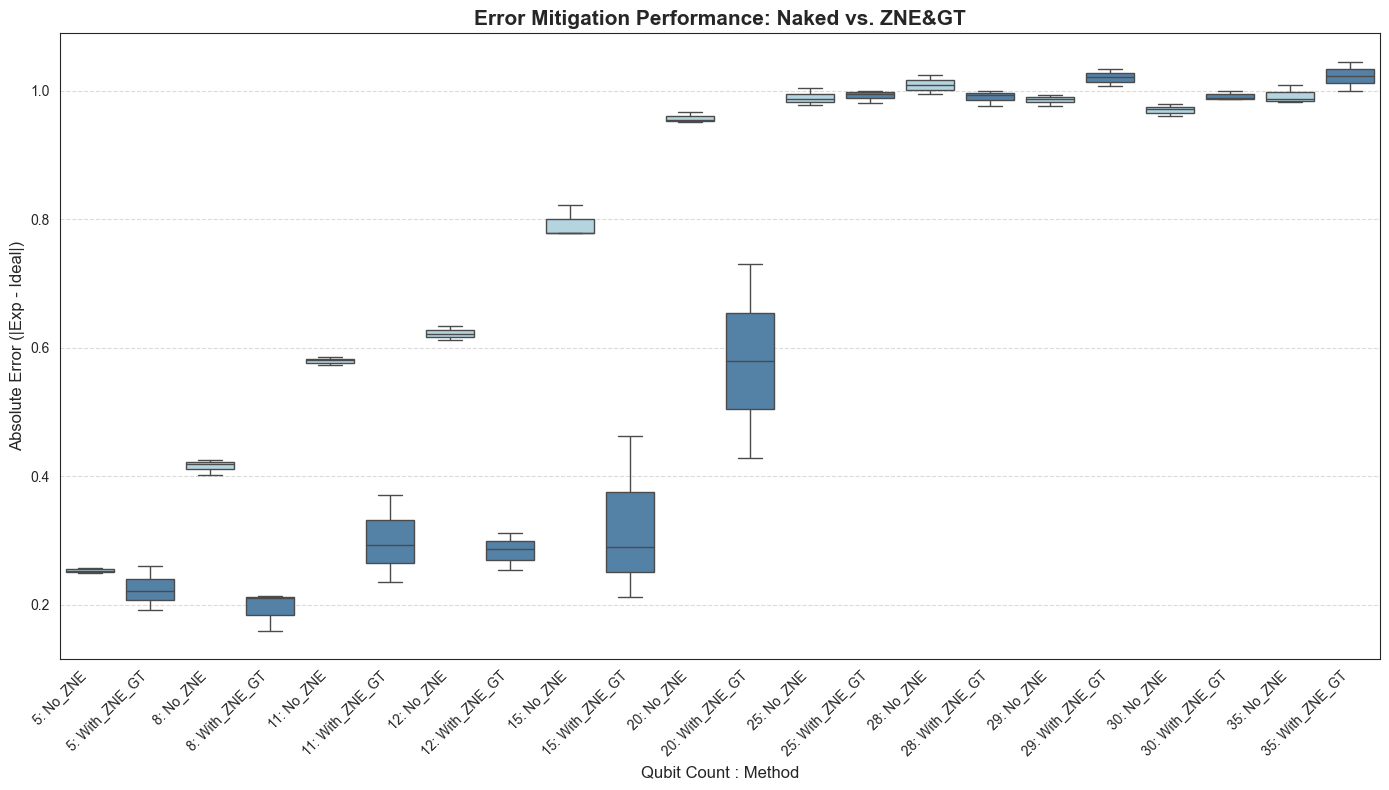

In [78]:
# 1. Data Preparation
# Create a combined label column: e.g., "3: No_ZNE", "3: With_ZNE"
df["Label"] = df["Qubits"].astype(str) + ": " + df["Mitigation"]

# Sort the dataframe so the X-axis is ordered logically (by Qubits, then by Mitigation)
# This ensures 2 qubits comes before 10 qubits, etc.
df = df.sort_values(by=["Qubits", "Mitigation"])

# 2. Setup Figure
plt.figure(figsize=(14, 8))
sns.set_style("white")  # Cleaner background like the template

# 3. Define Colors and Palette Logic
# Mapping your specific categories to the template's colors
# No_ZNE -> Light Blue (Baseline), With_ZNE -> Steel Blue (Mitigated)
color_map = {"No_ZNE": "#ADD8E6", "With_ZNE_GT": "#4682B4"}

unique_labels = df["Label"].unique()
# This list comprehension ensures the colors match the sorted order of the labels
palette_list = [color_map[label.split(": ")[1]] for label in unique_labels]

# 4. Create the Box Plot
sns.boxplot(
    data=df,
    x="Label",
    y="Abs_Error",
    hue="Label",  # Assign hue to Label to apply the palette
    palette=palette_list,
    dodge=False,  # Prevents grouping/shifting
    legend=False,  # Legend is redundant because x-axis labels explain it
    fliersize=3,  # Keep outlier dots small
)

# 5. Titles and Labels
plt.title("Error Mitigation Performance: Naked vs. ZNE&GT", fontsize=15, fontweight="bold")
plt.xlabel("Qubit Count : Method", fontsize=12)
plt.ylabel("Absolute Error (|Exp - Ideal|)", fontsize=12)

# 6. Adjust Axes and Grid (Matching the template style)
# Dynamic Y-limits with a small buffer
min_y = df["Abs_Error"].min()
max_y = df["Abs_Error"].max()
# Add 5% buffer to top and bottom
buffer = (max_y - min_y) * 0.05
plt.ylim(min_y - buffer, max_y + buffer)

# Grid only on Y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-labels for readability
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig("zne_comparison_flat.png", dpi=300)
plt.show()

In [93]:
# 1. Group by Qubits and Mitigation to get the MEAN Absolute Error across iterations
df_avg = df.groupby(["Qubits", "Mitigation"])["Abs_Error"].mean().unstack()

# 2. Calculate "Improvement" (Positive means ZNE reduced the error)
df_avg["Improvement"] = df_avg["No_ZNE"] - df_avg["With_ZNE_GT"]

In [99]:
# 1. Group by Qubits and Mitigation to get the MEAN Absolute Error across iterations
df_avg = df.groupby(["Qubits", "Mitigation"])["Abs_Error"].mean().unstack()

# 2. Calculate "Improvement" (Positive means ZNE reduced the error)
df_avg["Improvement"] = df_avg["No_ZNE"] - df_avg["With_ZNE_GT"]

# 3. Map your Custom Metrics
df_avg["H_ZNE"] = df.groupby("Qubits")["ZNE_Heuristic"].first()
df_avg["Cnt_2Q_Per_Qubit"] = df.groupby("Qubits")["Cnt 2q per qubit"].first()

# Reset index so 'Qubits' becomes a regular column for plotting
df_analysis = df_avg.reset_index()

# Check the data
print(df_analysis[["Qubits", "Improvement", "H_ZNE", "Cnt_2Q_Per_Qubit"]])

Mitigation  Qubits  Improvement     H_ZNE  Cnt_2Q_Per_Qubit
0                5     0.028954  0.049958             1.600
1                8     0.221256  0.123547             1.750
2               11     0.279576  0.240899             1.818
3               12     0.338373  0.252248             1.833
4               15     0.471652  0.420350             1.867
5               20     0.378315  0.790072             1.900
6               25    -0.002824  1.115797             1.920
7               28     0.019370  1.334951             1.929
8               29    -0.035348  1.485430             1.931
9               30    -0.021395  1.639447             1.933
10              35    -0.030033  2.277035             1.943


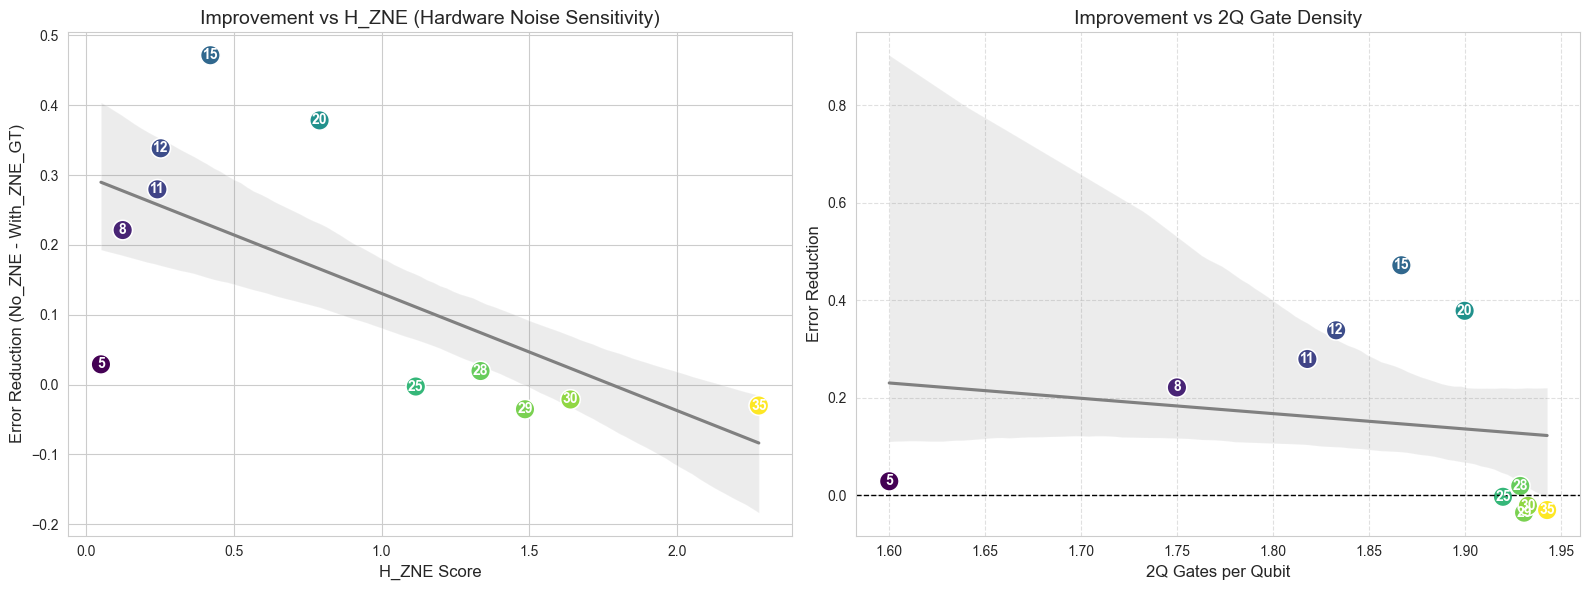

In [103]:
# Setup the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("whitegrid")

# --- PLOT 1: Improvement vs H_ZNE ---
sns.regplot(
    data=df_analysis,
    x="H_ZNE",
    y="Improvement",
    ax=axes[0],
    color="gray",
    scatter=False,
    ci=80,
)

# Add the colored dots (Scatter)
sns.scatterplot(
    data=df_analysis,
    x="H_ZNE",
    y="Improvement",
    hue="Qubits",
    palette="viridis",
    s=200,
    ax=axes[0],
    legend=False,
)

# Add qubit numbers inside bubbles
for idx, row in df_analysis.iterrows():
    axes[0].text(
        row["H_ZNE"],
        row["Improvement"],
        s=f"{int(row['Qubits'])}",
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

axes[0].set_title("Improvement vs H_ZNE (Hardware Noise Sensitivity)", fontsize=14)
axes[0].set_xlabel("H_ZNE Score", fontsize=12)
axes[0].set_ylabel("Error Reduction (No_ZNE - With_ZNE_GT)", fontsize=12)

# --- PLOT 2: Improvement vs 2Q Gates per Qubit ---
sns.regplot(
    data=df_analysis,
    x="Cnt_2Q_Per_Qubit",
    y="Improvement",
    ax=axes[1],
    color="gray",
    scatter=False,
    ci=80,
)

sns.scatterplot(
    data=df_analysis,
    x="Cnt_2Q_Per_Qubit",
    y="Improvement",
    hue="Qubits",
    palette="viridis",
    s=200,
    ax=axes[1],
    legend=False,
)

# Add qubit numbers inside bubbles
for idx, row in df_analysis.iterrows():
    axes[1].text(
        row["Cnt_2Q_Per_Qubit"],
        row["Improvement"],
        s=f"{int(row['Qubits'])}",
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

axes[1].set_title("Improvement vs 2Q Gate Density", fontsize=14)
axes[1].set_xlabel("2Q Gates per Qubit", fontsize=12)
axes[1].set_ylabel("Error Reduction", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].axhline(0, color="black", linewidth=1, linestyle="--")

plt.tight_layout()
plt.show()